In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

start_date = '2019-01-01'
end_date = '2022-01-01'

dates = pd.date_range(start=start_date, end=end_date, freq='D')
unix_dates = np.array([int(pd.Timestamp(d).timestamp()) for d in dates])
# Recreate a DatetimeIndex with a specific frequency

freq = 'D'  # Monthly frequency
date_rng = pd.date_range(start=start_date, end=end_date, freq=freq)

prices = np.sin(unix_dates)

for i in range(len(prices)):
    prices[i] = prices[i] + float(i) / 50

data = pd.DataFrame({'ds': date_rng, 'y': prices})

Доминирующая частота (период) в данных: 1097.00 дней


C:\Users\Skiv2\AppData\Local\Temp\ipykernel_43424\3726665425.py:5: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / fft_freq  # Преобразование частоты в период


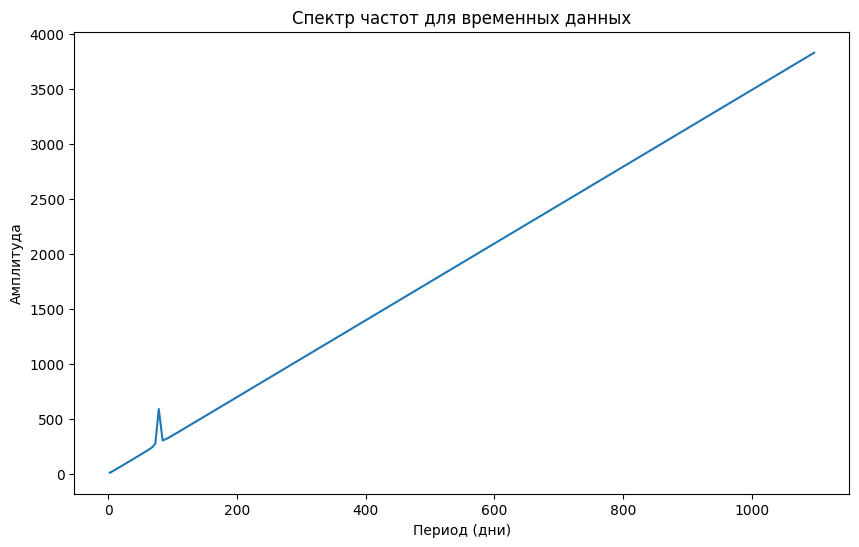

In [2]:
# Выполните преобразование Фурье
fft_result = np.fft.fft(prices)
fft_freq = np.fft.fftfreq(len(prices))
magnitude = np.abs(fft_result)
periods = 1 / fft_freq  # Преобразование частоты в период

# Отбросьте отрицательные частоты и нулевую частоту
positive_mask = fft_freq > 0
fft_freq = fft_freq[positive_mask]
magnitude = magnitude[positive_mask]
periods = periods[positive_mask]

# Найдите наиболее значимую частоту
max_frequency_index = np.argmax(magnitude)
dominant_period = periods[max_frequency_index]

# Выведите результаты
print(f"Доминирующая частота (период) в данных: {dominant_period:.2f} дней")

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(periods, magnitude)
plt.xlabel("Период (дни)")
plt.ylabel("Амплитуда")
plt.title("Спектр частот для временных данных")
plt.show()

In [4]:
prices_diff = np.diff(prices)

In [5]:
len(prices)

1097

In [6]:
len(prices_diff)

1096

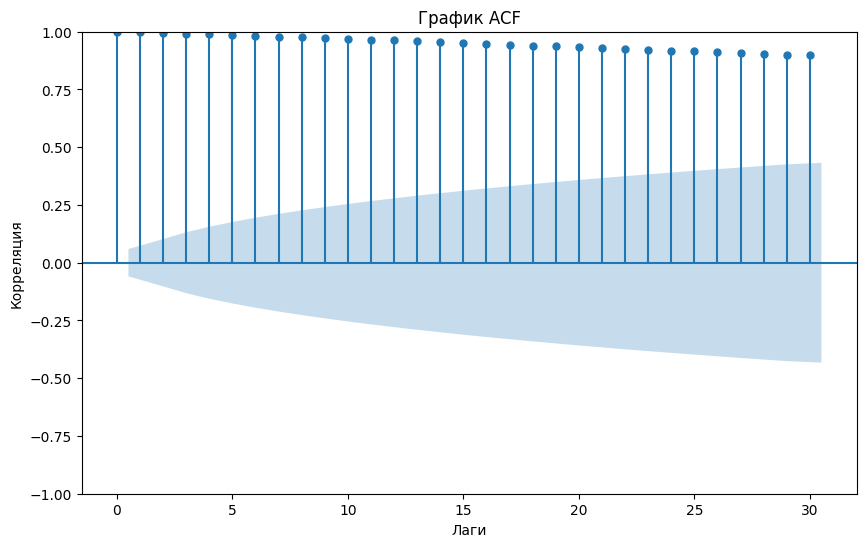

C:\Users\Skiv2\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


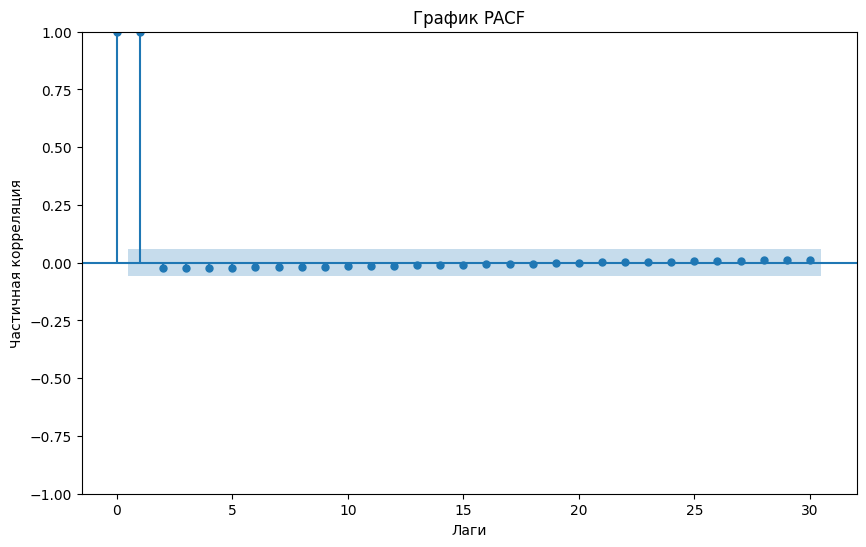

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
# Построение графика автокорреляционной функции (ACF)
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(prices, lags=30, ax=ax)  # Установите значение lags в соответствии с вашими потребностями
plt.xlabel('Лаги')
plt.ylabel('Корреляция')
plt.title('График ACF')
plt.show()
# Построение графика частичной автокорреляционной функции (PACF)
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(prices, lags=30, ax=ax)  # Установите значение lags в соответствии с вашими потребностями
plt.xlabel('Лаги')
plt.ylabel('Частичная корреляция')
plt.title('График PACF')
plt.show()

In [75]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(prices)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -0.11817635700894347
p-value: 0.9475977329255294


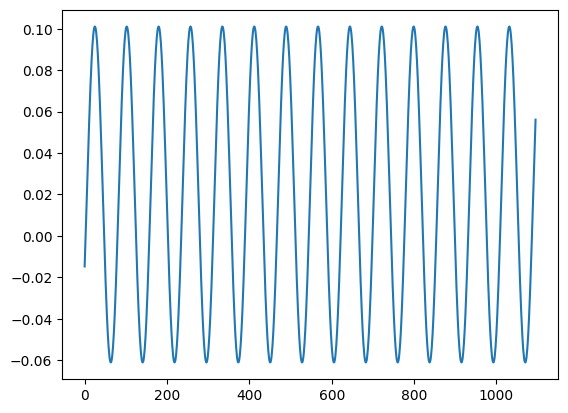

In [76]:
plt.plot(prices_diff)

In [9]:
train_size = int(len(prices) * 0.7)
test_size = len(prices) - train_size

In [77]:
model_data = pd.DataFrame({'Price': prices_diff[0:train_size], 'Date': date_rng[1:train_size + 1]})
model_data = model_data.set_index('Date', inplace = False)
model_data.head(10)

,Price
Date,
2019-01-02,-0.014774
2019-01-03,-0.008716
2019-01-04,-0.002470
2019-01-05,0.003924
2019-01-06,0.010425
2019-01-07,0.016988
2019-01-08,0.023571
2019-01-09,0.030131
2019-01-10,0.036624


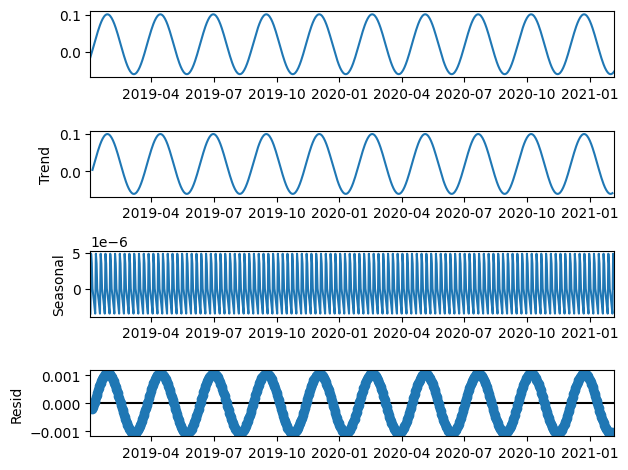

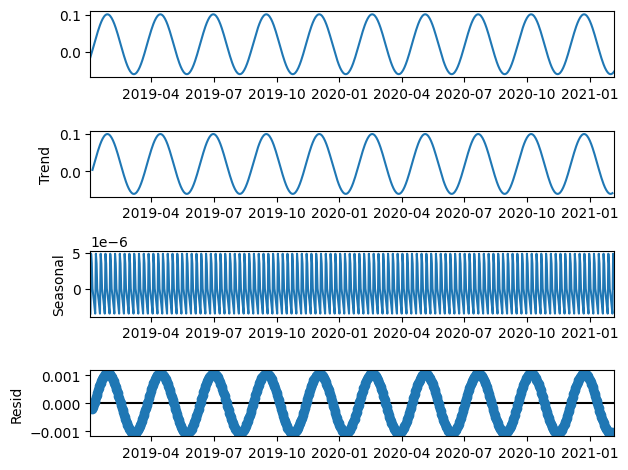

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose 
a = seasonal_decompose(model_data, model = "add")
a.plot()

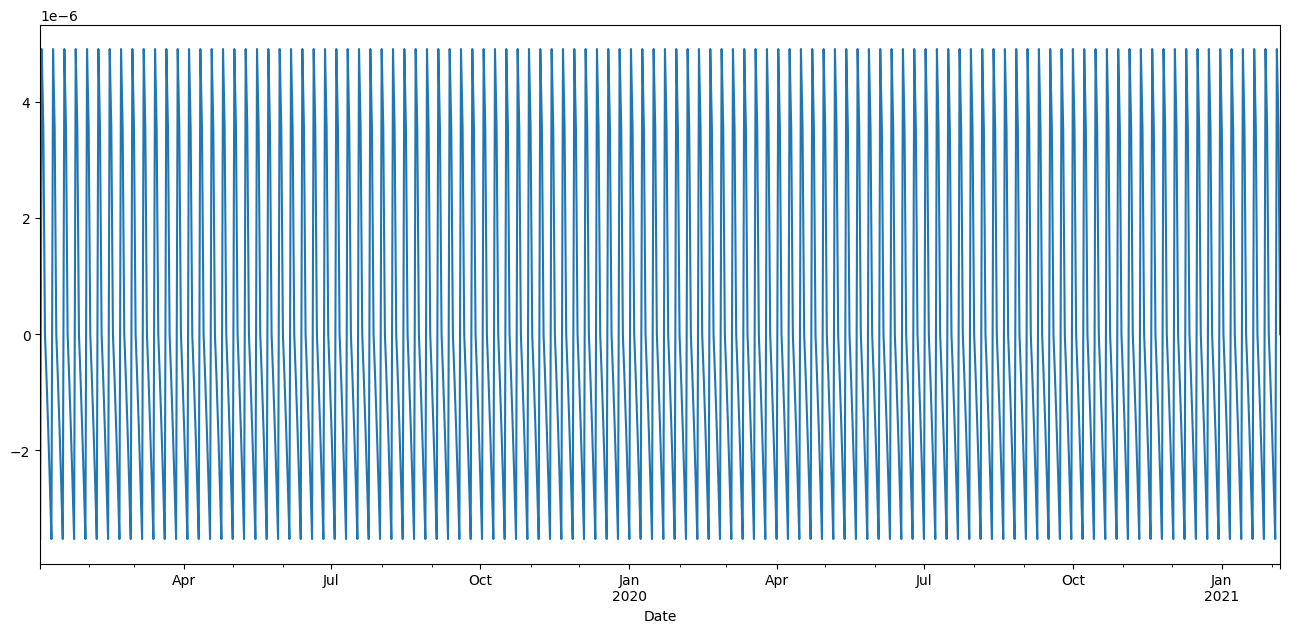

In [79]:
plt.figure(figsize = (16,7))
a.seasonal.plot();

In [80]:
# Выполните декомпозицию временного ряда для определения тренда и остатков
result = seasonal_decompose(model_data)

# Определите сезонный порядок на основе результатов декомпозиции
seasonal_order = (result.seasonal[0], result.seasonal[1], result.seasonal[2], 1000)

In [81]:
seasonal_order

(-3.526730888919428e-06, 4.916793582947017e-06, 3.545031531583262e-06, 1000)

In [82]:
model_data["Price"]

Date
2019-01-02   -0.014774
2019-01-03   -0.008716
2019-01-04   -0.002470
2019-01-05    0.003924
2019-01-06    0.010425
                ...   
2021-02-02   -0.060352
2021-02-03   -0.059175
2021-02-04   -0.057477
2021-02-05   -0.055268
2021-02-06   -0.052564
Name: Price, Length: 767, dtype: float64

In [100]:
#Importing the module
import pmdarima as pmd

arima_model = pmd.auto_arima(model_data["Price"], seasonal = False,
                              max_p = 7, max_d = 5, max_q = 7, max_P = 4, max_D = 4, max_Q = 4,
                              test = "pp", supress_warnings = True,
                              trace = True)

#Summary of the model
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,5,2)(0,0,0)[0]             : AIC=-13836.023, Time=2.89 sec
 ARIMA(0,5,0)(0,0,0)[0]             : AIC=-15688.942, Time=0.32 sec
 ARIMA(1,5,0)(0,0,0)[0]             : AIC=inf, Time=1.09 sec
 ARIMA(0,5,1)(0,0,0)[0]             : AIC=-15766.623, Time=1.03 sec
 ARIMA(1,5,1)(0,0,0)[0]             : AIC=-14862.763, Time=1.82 sec
 ARIMA(0,5,2)(0,0,0)[0]             : AIC=-13122.457, Time=0.71 sec
 ARIMA(1,5,2)(0,0,0)[0]             : AIC=-12365.401, Time=1.86 sec
 ARIMA(0,5,1)(0,0,0)[0] intercept   : AIC=-16190.746, Time=1.06 sec
 ARIMA(0,5,0)(0,0,0)[0] intercept   : AIC=21.445, Time=1.79 sec
 ARIMA(1,5,1)(0,0,0)[0] intercept   : AIC=-12.801, Time=3.46 sec
 ARIMA(0,5,2)(0,0,0)[0] intercept   : AIC=-12472.498, Time=1.85 sec
 ARIMA(1,5,0)(0,0,0)[0] intercept   : AIC=inf, Time=2.31 sec
 ARIMA(1,5,2)(0,0,0)[0] intercept   : AIC=-16119.641, Time=4.73 sec

Best model:  ARIMA(0,5,1)(0,0,0)[0] intercept
Total fit time: 24.934 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  767
Model:               SARIMAX(0, 5, 1)   Log Likelihood                8098.373
Date:                Sun, 20 Aug 2023   AIC                         -16190.746
Time:                        14:52:44   BIC                         -16176.838
Sample:                    01-02-2019   HQIC                        -16185.391
                         - 02-06-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.539e-06   1.55e-05     -0.099      0.921   -3.19e-05    2.89e-05
ma.L1       7.185e-07    2.3e-11   3.12e+04      0.000    7.18e-07    7.19e-07
sigma2          9e-11   5.28e-10      0.170      0.865   -9.45e-10    1.13e-09
===================================================================================
Ljung-Box (L1) (Q):                 653.22   Jarque-Bera (JB):                71.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.35
Prob(H) (two-sided):                  0.80   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [101]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
arima_model = SARIMAX(model_data["Price"], order = (2, 1, 0))
arima_result = arima_model.fit()
arima_result.summary()

C:\Users\Skiv2\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Skiv2\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Skiv2\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  767
Model:               SARIMAX(2, 1, 0)   Log Likelihood                2610.288
Date:                Sun, 20 Aug 2023   AIC                          -5214.576
Time:                        14:52:44   BIC                          -5200.653
Sample:                    01-02-2019   HQIC                         -5209.216
                         - 02-06-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       8.512e-07      2.970   2.87e-07      1.000      -5.822       5.822
ar.L2       8.437e-07      2.978   2.83e-07      1.000      -5.837       5.837
sigma2         0.0002   1.88e-05      8.026      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                 761.88   Jarque-Bera (JB):                71.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             0.02
Prob(H) (two-sided):                  0.66   Kurtosis:                         1.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [102]:
arima_pred = arima_result.predict(start = len(model_data), end = len(prices) - 1, typ="levels")
arima_pred

2021-02-07   -0.052564
2021-02-08   -0.052564
2021-02-09   -0.052564
2021-02-10   -0.052564
2021-02-11   -0.052564
                ...   
2021-12-29   -0.052564
2021-12-30   -0.052564
2021-12-31   -0.052564
2022-01-01   -0.052564
2022-01-02   -0.052564
Freq: D, Name: predicted_mean, Length: 330, dtype: float64

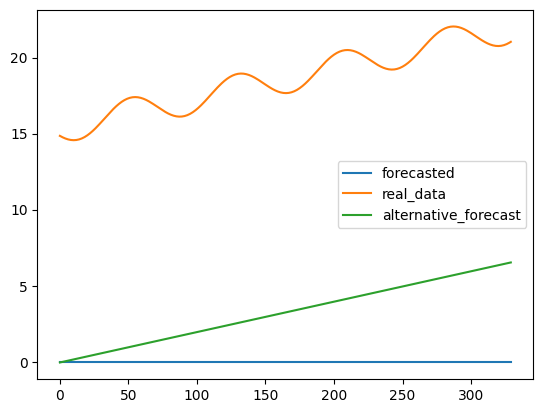

In [103]:
plt.plot(arima_pred.values, label = "forecasted")
new_pred = list()
for i in range(len(arima_pred.values)):
    new_pred.append(arima_pred.values[i] + float(i) / 50)
plt.plot(prices[train_size:], label = "real_data")
plt.plot(new_pred, label = "alternative_forecast")
plt.legend()

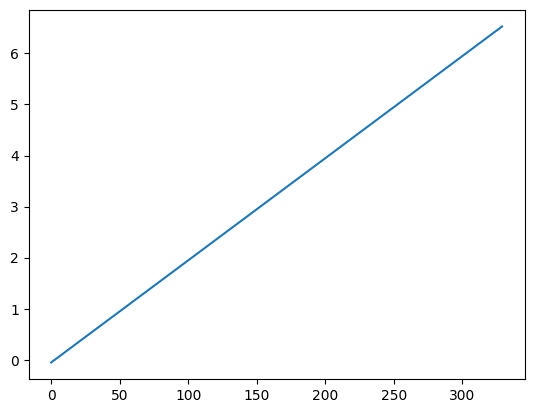

In [104]:
plt.plot(new_pred, label = "alternative_forecast")

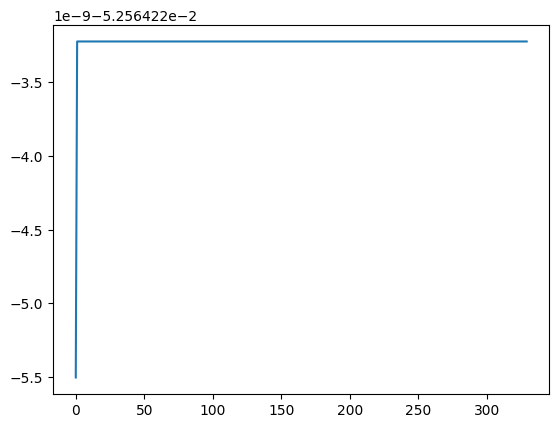

In [105]:
plt.plot(arima_pred.values, label = "forecasted")

In [106]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
arima_model = SARIMAX(model_data["Price"], order = (2, 5, 1))
arima_result = arima_model.fit()
arima_result.summary()

C:\Users\Skiv2\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Skiv2\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  767
Model:               SARIMAX(2, 5, 1)   Log Likelihood                6480.273
Date:                Sun, 20 Aug 2023   AIC                         -12952.545
Time:                        14:52:46   BIC                         -12934.002
Sample:                    01-02-2019   HQIC                        -12945.405
                         - 02-06-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9934   4.41e-12   4.52e+11      0.000       1.993       1.993
ar.L2         -1.0000   1.64e-08  -6.11e+07      0.000      -1.000      -1.000
ma.L1         -0.9327      0.000  -6059.790      0.000      -0.933      -0.932
sigma2      5.531e-09    4.1e-10     13.484      0.000    4.73e-09    6.33e-09
===================================================================================
Ljung-Box (L1) (Q):                  33.76   Jarque-Bera (JB):          13968311.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.01   Skew:                            25.06
Prob(H) (two-sided):                  0.00   Kurtosis:                       664.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.72e+23. Standard errors may be unstable.
"""

In [107]:
arima_pred = arima_result.predict(start = len(model_data), end = len(prices) - 1, typ="levels")
arima_pred

2021-02-07   -0.049383
2021-02-08   -0.045744
2021-02-09   -0.041673
2021-02-10   -0.037196
2021-02-11   -0.032342
                ...   
2021-12-29    0.070970
2021-12-30    0.077747
2021-12-31    0.084370
2022-01-01    0.090799
2022-01-02    0.096993
Freq: D, Name: predicted_mean, Length: 330, dtype: float64

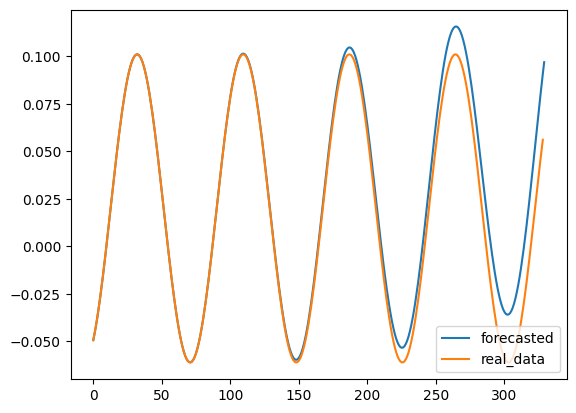

In [108]:
plt.plot(arima_pred.values, label = "forecasted")
new_pred = list()
for i in range(len(arima_pred.values)):
    new_pred.append(arima_pred.values[i] + float(i) / 50)
plt.plot(prices_diff[train_size:], label = "real_data")
#plt.plot(new_pred, label = "alternative_forecast")
plt.legend()